In [3]:
import os
os.chdir('../')

In [4]:
from lib.pull_tweets import get_twitter_client, get_user_tweets, get_texts_and_user
import twitter, yaml
import pandas as pd
import seaborn as sns
import csv
import re
from nltk.corpus import stopwords
from unidecode import unidecode
from lib.cleaning_module import clean_text
import pickle
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, silhouette_score
import sklearn.neural_network as nn
from lib.general_model import general_model, build_vectorizer
from lib.prediction_module import prediction_prob
from sklearn.externals import joblib
from tweepy import OAuthHandler
import tweepy
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.pipeline import Pipeline

In [5]:
access_key =  '823714388905336832-Vk8UvBNUR7VodGhHzdKEmK5GNs3ULxB'
access_secret = 'XK86kGwlp4zwDzxYhYc2oHu0qJIE11uRp83Ex6TUg4JCg'
consumer_token =  'N5dNhpdbhfLbn5Z94XyRVpr3I'
consumer_secret = 'G8CfW44BA1mofPBh3bP0gRGp6hokuw5h3PlZCUkPRYMccyYznE'

In [6]:
def get_user_tweets(screen_name):

    auth = OAuthHandler(consumer_token, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth)
    
    alltweets = []    
    new_tweets = api.user_timeline(screen_name = screen_name,count=200)
    alltweets.extend(new_tweets)
    user=api.get_user(screen_name=screen_name)
    oldest = alltweets[-1].id - 1
    
    while len(new_tweets) > 0:
        new_tweets = api.user_timeline(screen_name = screen_name, count=200,max_id=oldest)
        alltweets.extend(new_tweets)
        oldest = alltweets[-1].id - 1
    return alltweets

In [7]:
new_user_tweets = get_user_tweets('iamjamiefoxx')
all_tw = pd.concat([pd.DataFrame([[i.user.screen_name, i.text]], 
                        columns=['user','text']) 
                        for i in new_user_tweets],axis=0).reset_index(drop=True)

In [8]:
tfid = joblib.load('data/pickles/tfid_1.pkl')
svd = joblib.load('data/pickles/svd_1.pkl')
mlpc = joblib.load('data/pickles/mlpc_2.pkl')

In [9]:
tfid = tfid.fit_transform(all_tw['text'])
transformed_X = svd.fit_transform(tfid)
all_proba = mlpc.predict_proba(transformed_X)

In [11]:
Archetypes = {  0 : 'The Innocent', 
                1 : 'The Everyperson', 
                2 : 'The Hero',
                3 : 'The Nurturer',
                4 : 'The Explorer',
                5 : 'The Rebel',
                6 : 'The Lover',
                7 : 'The Creator',
                8 : 'The Jester',
                9 : 'The Sage',
                10 : 'The Magician',
                11 : 'The Ruler'}

In [12]:
inn_avg = np.mean([item[0] for item in all_proba])
every_avg = np.mean([item[1] for item in all_proba])
hero_avg = np.mean([item[2] for item in all_proba])
nurt_avg = np.mean([item[3] for item in all_proba])
exp_avg = np.mean([item[4] for item in all_proba])
rebel_avg = np.mean([item[5] for item in all_proba])
lover_avg = np.mean([item[6] for item in all_proba])
creat_avg = np.mean([item[7] for item in all_proba])
jest_avg = np.mean([item[8] for item in all_proba])
sage_avg = np.mean([item[9] for item in all_proba])
mag_avg = np.mean([item[10] for item in all_proba])
ruler_avg = np.mean([item[11] for item in all_proba])
all_tweet_avg = [inn_avg, every_avg, hero_avg, nurt_avg, exp_avg, rebel_avg, lover_avg, creat_avg, jest_avg, sage_avg, mag_avg, ruler_avg]

In [13]:
results = pd.DataFrame(zip([value for value in Archetypes.values()],  all_tweet_avg))
results.rename(index=str, columns={0 : 'archetype', 1 : 'rank' }, inplace=True)
results = results.sort_values(['rank'], ascending=True)
results['percentage'] = pd.Series([round(val, 2) for val in results['rank']], index=results.index)
results['percentage'] = pd.Series(["{0:.2f}%".format(val * 100) for val in results['rank']], index=results.index)

In [14]:
results

,archetype,rank,percentage
5,The Rebel,0.039781,3.98%
7,The Creator,0.052564,5.26%
2,The Hero,0.059779,5.98%
11,The Ruler,0.073100,7.31%
3,The Nurturer,0.073345,7.33%
6,The Lover,0.075084,7.51%
1,The Everyperson,0.075922,7.59%
0,The Innocent,0.081014,8.10%
4,The Explorer,0.083585,8.36%
9,The Sage,0.084105,8.41%


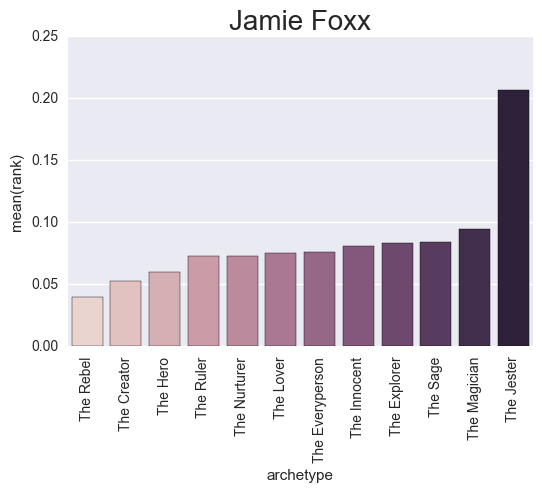

In [20]:
color = sns.cubehelix_palette(n_colors=12)
g = sns.barplot(x=results['archetype'], y=results['rank'], palette=color)
g.set_xticklabels(results['archetype'], rotation='vertical')
g.axes.set_title('Jamie Foxx', fontsize=20)